Add Bullpen to Model

    - In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    - Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp7.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2000) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
df.shape

(132040, 611)

In [5]:
hv_mean = df_train.home_victory.mean()

In [6]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

Let's add in some basic bullpen features

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            ]

In [10]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[616]	valid_0's binary_logloss: 0.679846

Vegas probs: 0.6675629431340582 on test
model probs: 0.6748723078644754 on test

Difference: 0.007309364730417212 on test

Avg Shap Vals
Intercept               0.165183
Strt_SO_perc_10_v       0.121674
Strt_SO_perc_10_h       0.088524
Strt_WHIP_35_v          0.071397
OBP_162_h               0.069284
SLG_162_h               0.066426
OBP_162_v               0.057615
Strt_WHIP_35_h          0.056235
SLG_162_v               0.053196
Strt_TB_BB_perc_35_h    0.043702
Strt_TB_BB_perc_35_v    0.034651
Strt_H_BB_perc_35_h     0.032060
Strt_H_BB_perc_35_v     0.010364
dtype: float64


In [11]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            ]

In [12]:
d2 = try_features(features2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	valid_0's binary_logloss: 0.679281

Vegas probs: 0.6675629431340582 on test
model probs: 0.673687134945222 on test

Difference: 0.006124191811163859 on test

Avg Shap Vals
Intercept               0.164936
Strt_SO_perc_10_v       0.126659
Strt_SO_perc_10_h       0.075638
Strt_WHIP_35_v          0.067329
OBP_162_h               0.061475
SLG_162_h               0.059514
Strt_WHIP_35_h          0.052532
SLG_162_v               0.051526
OBP_162_v               0.049823
Bpen_SO_perc_35_v       0.037216
Strt_TB_BB_perc_35_h    0.037075
Strt_H_BB_perc_35_h     0.031227
Strt_TB_BB_perc_35_v    0.026034
Bpen_SO_perc_35_h       0.022127
Bpen_TB_BB_perc_35_v    0.021875
Bpen_WHIP_35_v          0.013434
Bpen_WHIP_35_h          0.010977
Bpen_H_BB_perc_35_h     0.008727
Strt_H_BB_perc_35_v     0.007134
Bpen_TB_BB_perc_35_h    0.004921
Bpen_H_BB_perc_35_v     0.004288
dtype: float64


In [13]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [14]:
d3 = try_features(features3, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.678923

Vegas probs: 0.6675629431340582 on test
model probs: 0.6728821240288574 on test

Difference: 0.005319180894799214 on test

Avg Shap Vals
Intercept               0.165218
Strt_SO_perc_10_v       0.125488
Strt_SO_perc_10_h       0.079118
Strt_WHIP_35_v          0.067990
OBP_162_h               0.062491
SLG_162_h               0.054652
Strt_WHIP_35_h          0.053339
OBP_162_v               0.051630
SLG_162_v               0.051339
Bpen_SO_perc_75_v       0.049859
Strt_TB_BB_perc_35_h    0.036532
Strt_H_BB_perc_35_h     0.029794
Strt_TB_BB_perc_35_v    0.026624
Bpen_SO_perc_75_h       0.017990
Bpen_TB_BB_perc_10_v    0.017418
Bpen_WHIP_75_h          0.014853
Bpen_SO_perc_10_v       0.013768
Bpen_SO_perc_35_v       0.013477
Bpen_TB_BB_perc_75_v    0.012947
Bpen_H_BB_perc_75_h     0.012878
Bpen_TB_BB_perc_35_v    0.011074
Bpen_SO_perc_10_h       0.008577

In [15]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_75_h','Strt_WHIP_75_v',
            'Strt_TB_BB_perc_75_h', 'Strt_TB_BB_perc_75_v',
            'Strt_H_BB_perc_75_h', 'Strt_H_BB_perc_75_v',
            'Strt_SO_perc_75_h', 'Strt_SO_perc_75_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
            'Strt_H_BB_perc_10_h', 'Strt_H_BB_perc_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [16]:
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[640]	valid_0's binary_logloss: 0.678816

Vegas probs: 0.6675629431340582 on test
model probs: 0.672957328377768 on test

Difference: 0.005394385243709832 on test

Avg Shap Vals
Intercept               0.165181
Strt_SO_perc_10_v       0.093339
OBP_162_h               0.061067
SLG_162_h               0.051088
OBP_162_v               0.048657
Strt_SO_perc_10_h       0.048188
SLG_162_v               0.046437
Bpen_SO_perc_75_v       0.041859
Strt_WHIP_75_v          0.039138
Strt_WHIP_35_v          0.030637
Strt_H_BB_perc_75_h     0.027474
Strt_WHIP_35_h          0.027053
Strt_SO_perc_35_h       0.026206
Strt_WHIP_75_h          0.025501
Strt_SO_perc_35_v       0.025316
Strt_TB_BB_perc_75_h    0.020690
Strt_TB_BB_perc_35_h    0.018204
Bpen_WHIP_75_h          0.017409
Bpen_TB_BB_perc_10_v    0.017221
Bpen_SO_perc_75_h       0.016820
Strt_TB_BB_perc_35_v    0.016112
Bpen_SO_perc_10_v       0.012168


In [17]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [18]:
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[667]	valid_0's binary_logloss: 0.679084

Vegas probs: 0.6675629431340582 on test
model probs: 0.6730518393229485 on test

Difference: 0.005488896188890369 on test

Avg Shap Vals
Intercept               0.165174
Strt_SO_perc_10_v       0.119993
Strt_SO_perc_10_h       0.082351
Strt_WHIP_35_v          0.065203
OBP_162_h               0.058201
Strt_WHIP_35_h          0.052961
SLG_162_h               0.051517
SLG_162_v               0.045191
ERR_162_v               0.044137
OBP_162_v               0.043260
Bpen_SO_perc_75_v       0.034625
ERR_162_h               0.032666
Strt_TB_BB_perc_35_h    0.028721
Strt_H_BB_perc_35_h     0.028160
Strt_TB_BB_perc_35_v    0.027270
SB_162_v                0.021774
Bpen_SO_perc_75_h       0.018226
Bpen_TB_BB_perc_10_v    0.016056
SB_162_h                0.015672
Bpen_SO_perc_35_v       0.013849
Bpen_H_BB_perc_75_h     0.011517
Bpen_TB_BB_perc_75_v    0.011017

In [19]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

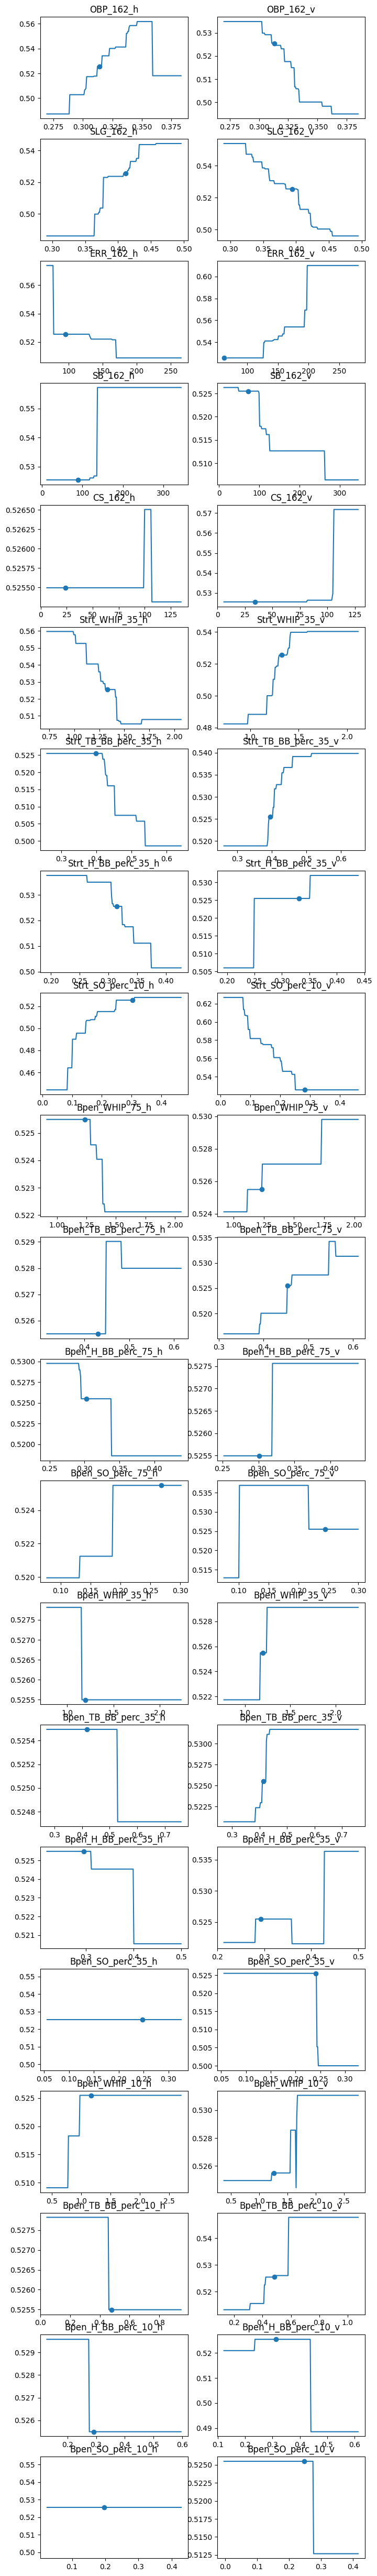

In [20]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [21]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [22]:
df_train = df[(df.season>1901) & (df.season<=2000) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [23]:
len(df.OBP_162_h)

132040

In [24]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]


In [25]:
d6 = try_features(features6)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's binary_logloss: 0.679164

Vegas probs: 0.6675629431340582 on test
model probs: 0.6727565421629706 on test

Difference: 0.005193599028912477 on test

Avg Shap Vals
Intercept               0.165186
Strt_SO_perc_10_v       0.119684
Strt_SO_perc_10_h       0.077815
Strt_WHIP_35_v          0.064392
OBP_162_h               0.057857
Strt_WHIP_35_h          0.052143
SLG_162_h               0.048501
OBP_162_v               0.044623
ERR_162_v               0.043902
SLG_162_v               0.041399
Bpen_SO_perc_75_v       0.038377
Strt_TB_BB_perc_35_h    0.031327
ERR_162_h               0.030269
Strt_H_BB_perc_35_h     0.028382
SBadj_162_v             0.027603
Strt_TB_BB_perc_35_v    0.024738
Bpen_TB_BB_perc_10_v    0.018821
Bpen_SO_perc_75_h       0.018452
Bpen_H_BB_perc_75_h     0.013563
Bpen_WHIP_75_h          0.012023
Bpen_TB_BB_perc_75_v    0.011951
Bpen_SO_perc_35_v       0.010553

In [26]:

len(features6)

40

Let's analyze model 3 (our best model so far)

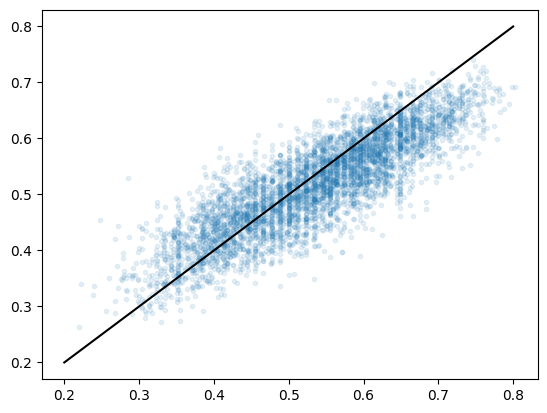

In [27]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

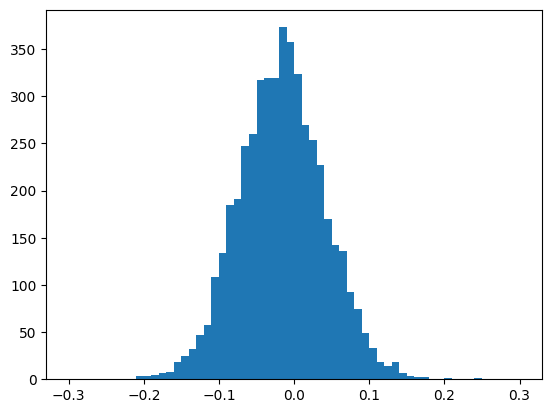

In [28]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [31]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.6783627072041728, 0.637749149773395)

In [32]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6723722162002012, 0.6703367878418648)

Conclusions
    - Still about 40 bps away from Vegas probabilities (down from ~70)
    - When our model and Vegas "disagree", Vegas is generally right!

    - We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

Next Steps

    - Get individual batter data
    - Make features based on the actual lineup
    - Analyze runs scored (over/under)
    - Perhaps the model for runs scored will help with the moneyline model